# Лабораторная работа 6: Многослойный перцептрон для классификации грибов

**Цель работы:** создать архитектуру многослойного персептрона для классификации грибов из датасета Mushroom Dataset. Обучить нейронную сеть и оценить ее качество с помощью метрик accuracy, precision, recall, F1-меры. Также построить ROC-кривую.

## Описание датасета

Датасет содержит информацию о грибах, включая их характеристики и информацию о том, съедобны они или ядовиты. Все переменные являются категориальными.

Ссылка на описание датасета: [Mushroom Dataset](https://archive.ics.uci.edu/ml/datasets/Mushroom)

## Импорт необходимых библиотек


In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc


In [16]:
column_names = [
    'class', 'cap-shape', 'cap-surface', 'cap-color', 'bruises', 'odor',
    'gill-attachment', 'gill-spacing', 'gill-size', 'gill-color',
    'stalk-shape', 'stalk-root', 'stalk-surface-above-ring',
    'stalk-surface-below-ring', 'stalk-color-above-ring',
    'stalk-color-below-ring', 'veil-type', 'veil-color', 'ring-number',
    'ring-type', 'spore-print-color', 'population', 'habitat'
]

data = pd.read_csv('agaricus-lepiota.data', names=column_names)
data.head()


,class,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,...,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
0,p,x,s,n,t,p,f,c,n,k,...,s,w,w,p,w,o,p,k,s,u
1,e,x,s,y,t,a,f,c,b,k,...,s,w,w,p,w,o,p,n,n,g
2,e,b,s,w,t,l,f,c,b,n,...,s,w,w,p,w,o,p,n,n,m
3,p,x,y,w,t,p,f,c,n,n,...,s,w,w,p,w,o,p,k,s,u
4,e,x,s,g,f,n,f,w,b,k,...,s,w,w,p,w,o,e,n,a,g


In [17]:
# Заменим отсутствующие значения на наиболее частую категорию
data.replace('?', np.nan, inplace=True)
data = data.fillna(data.mode().iloc[0])


In [18]:
# Разделяем признаки и метки
X = data.drop('class', axis=1)
y = data['class']

# Кодирование меток
y = y.map({'e': 0, 'p': 1}).values.reshape(-1, 1)

# One-hot кодирование категориальных признаков
X_encoded = pd.get_dummies(X)
X_encoded.head()


,cap-shape_b,cap-shape_c,cap-shape_f,cap-shape_k,cap-shape_s,cap-shape_x,cap-surface_f,cap-surface_g,cap-surface_s,cap-surface_y,...,population_s,population_v,population_y,habitat_d,habitat_g,habitat_l,habitat_m,habitat_p,habitat_u,habitat_w
0,0,0,0,0,0,1,0,0,1,0,...,1,0,0,0,0,0,0,0,1,0
1,0,0,0,0,0,1,0,0,1,0,...,0,0,0,0,1,0,0,0,0,0
2,1,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,1,0,0,0
3,0,0,0,0,0,1,0,0,0,1,...,1,0,0,0,0,0,0,0,1,0
4,0,0,0,0,0,1,0,0,1,0,...,0,0,0,0,1,0,0,0,0,0


In [19]:
# Преобразование в numpy массивы
X = X_encoded.values

### Нормализация данных
Нормализация не требуется, так как все признаки бинарные после one-hot кодирования


## Разделение на обучающую и тестовую выборки


In [20]:
indices = np.arange(X.shape[0])
np.random.shuffle(indices)
X = X[indices]
y = y[indices]

split_ratio = 0.8
split_index = int(split_ratio * X.shape[0])

X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]


In [21]:
class MLP:
    def __init__(self, input_size, hidden_sizes, output_size):
        self.weights = []
        self.biases = []
        
        layer_sizes = [input_size] + hidden_sizes + [output_size]
        
        for i in range(len(layer_sizes) - 1):
            weight = np.random.randn(layer_sizes[i], layer_sizes[i+1]) * np.sqrt(2 / layer_sizes[i])
            bias = np.zeros((1, layer_sizes[i+1]))
            self.weights.append(weight)
            self.biases.append(bias)
    
    def sigmoid(self, x):
        return 1 / (1 + np.exp(-x))
    
    def sigmoid_derivative(self, x):
        sx = self.sigmoid(x)
        return sx * (1 - sx)
    
    def forward(self, X):
        self.z_values = []
        self.a_values = [X]
        
        for i in range(len(self.weights)):
            z = np.dot(self.a_values[-1], self.weights[i]) + self.biases[i]
            self.z_values.append(z)
            a = self.sigmoid(z)
            self.a_values.append(a)
        
        return self.a_values[-1]
    
    def backward(self, y_true):
        m = y_true.shape[0]
        deltas = []
        
        # Ошибка на выходном слое
        delta = (self.a_values[-1] - y_true) * self.sigmoid_derivative(self.z_values[-1])
        deltas.append(delta)
        
        # Ошибки на скрытых слоях
        for i in reversed(range(len(self.weights)-1)):
            delta = np.dot(deltas[-1], self.weights[i+1].T) * self.sigmoid_derivative(self.z_values[i])
            deltas.append(delta)
        
        deltas.reverse()
        
        # Обновление весов и смещений
        dW = []
        db = []
        
        for i in range(len(self.weights)):
            dW.append(np.dot(self.a_values[i].T, deltas[i]) / m)
            db.append(np.sum(deltas[i], axis=0, keepdims=True) / m)
        
        return dW, db
    
    def update_params(self, dW, db, learning_rate):
        for i in range(len(self.weights)):
            self.weights[i] -= learning_rate * dW[i]
            self.biases[i] -= learning_rate * db[i]
    
    def compute_loss(self, y_true, y_pred):
        m = y_true.shape[0]
        loss = - (1/m) * np.sum(y_true * np.log(y_pred + 1e-8) + (1 - y_true) * np.log(1 - y_pred + 1e-8))
        return loss
    
    def predict(self, X):
        y_pred = self.forward(X)
        return (y_pred >= 0.5).astype(int)
    
    def fit(self, X, y, epochs, learning_rate):
        losses = []
        for epoch in range(epochs):
            y_pred = self.forward(X)
            loss = self.compute_loss(y, y_pred)
            dW, db = self.backward(y)
            self.update_params(dW, db, learning_rate)
            losses.append(loss)
            if (epoch+1) % 100 == 0:
                print(f'Epoch {epoch+1}/{epochs}, Loss: {loss}')
        return losses


## Обучение модели


In [22]:
input_size = X_train.shape[1]
hidden_sizes = [16, 8]  # Два скрытых слоя
output_size = 1  # Один выходной нейрон для бинарной классификации

mlp = MLP(input_size, hidden_sizes, output_size)

epochs = 1000
learning_rate = 0.1

losses = mlp.fit(X_train, y_train, epochs, learning_rate)


Epoch 100/1000, Loss: 0.6911563236581528
Epoch 200/1000, Loss: 0.6805327433867783
Epoch 300/1000, Loss: 0.6682619860062704
Epoch 400/1000, Loss: 0.6530839579036996
Epoch 500/1000, Loss: 0.6340111079209223
Epoch 600/1000, Loss: 0.6104066382977553
Epoch 700/1000, Loss: 0.582058350595455
Epoch 800/1000, Loss: 0.549445914382214
Epoch 900/1000, Loss: 0.5140083563076095
Epoch 1000/1000, Loss: 0.47789475142453924


### График функции потерь


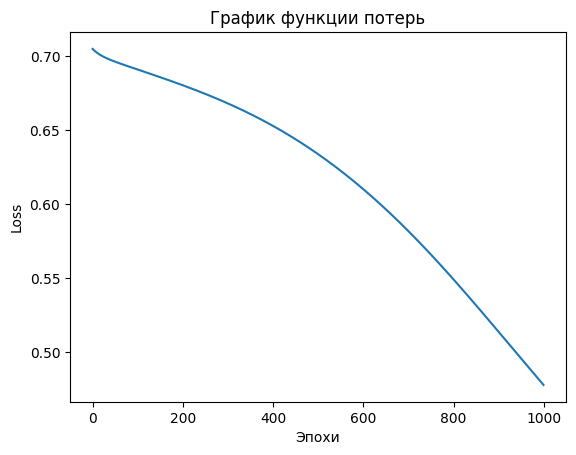

In [23]:
plt.plot(losses)
plt.title('График функции потерь')
plt.xlabel('Эпохи')
plt.ylabel('Loss')
plt.show()


In [24]:
# Предсказания на тестовой выборке
y_pred_prob = mlp.forward(X_test)
y_pred = mlp.predict(X_test)


In [25]:
### Вычисление метрик


In [26]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1-Measure: {f1:.4f}')


Accuracy: 0.8997
Precision: 0.9726
Recall: 0.8153
F1-Measure: 0.8870


In [27]:
## Построение ROC-кривой


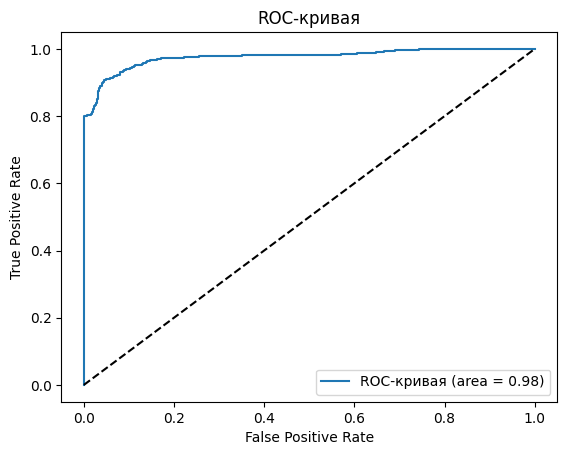

In [28]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, label=f'ROC-кривая (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.legend(loc="lower right")
plt.show()


## Вывод

Мы успешно создали и обучили многослойный персептрон для классификации грибов. Модель показала высокое качество классификации, что подтверждается метриками accuracy, precision, recall и F1-мерой. ROC-кривая также демонстрирует хорошую способность модели различать классы.

## Ссылки

- [Описание датасета Mushroom Dataset](https://archive.ics.uci.edu/ml/datasets/Mushroom)
